<a href="https://colab.research.google.com/github/LPugens/imersao-dados-desafio-final/blob/main/Notebooks/03_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#Deep Learning
Aqui nós vamos tentar desenvolver um algoritmo de deep-learning que conseguirá predizer os MoAs, dada a assinatura de ativação genética do experimento.

Nós vamos fazer uso das ferramentas de deep-learning da biblioteca Tensorflow

![deep-learning](https://raw.githubusercontent.com/LPugens/imersao-dados-desafio-final/main/fig3_deep_learning.jpg)

Fonte [Artigo da Science](https://www.nature.com/articles/nrd.2017.232.pdf?origin=ppub)

**Importante**: Aqui, eu assumo que a relação de causa e efeito se dá entre as taxas de ativação genética e os MoA sem considerar as taxas de sobrevivência celular.

##Carregando os dados

In [2]:
dados_experimentos = 'https://github.com/LPugens/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
dados_experimentos = pd.read_csv(dados_experimentos, compression = 'zip')
dados_experimentos.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [3]:
dados_resultados = 'https://github.com/LPugens/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'
dados_resultados = pd.read_csv(dados_resultados)
dados_resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Pré-processamento dos dados

Unindo os dados dos experimentos e dados dos resultados em um único DataFrame.

In [4]:
dados = pd.merge(left=dados_experimentos, right=dados_resultados, on='id')
dados.head()

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Transoformando as features de `tempo` e `dose` em one-hot-encoding.

In [5]:
dados = pd.get_dummies(data=dados, columns=['tempo', 'dose'])

Para este experimento, vamos considerar apenas os `g`s

A features `droga` pode parecer importante até mesmo par um processamento a partir dos seus nomes em `embeddings` seria interessante. Mas como os labels estão anonimizados, não temos muito o que fazer com eles.

In [6]:
dados = dados.drop(labels=['id', 'tratamento'], axis=1)

In [7]:
dados = dados.filter(regex=r'^(?!c-)')

Para melhorar o desempenho dos algoritmos, é interessante normalizar os dados.

Dadas as informações do dataset, podemos normalizar os `g`s, para apresentarem média = 0 e variancia = 1

In [8]:
print(f'Média dos Gs {dados.loc[:, "g-0":"g-771"].mean()}')
print(f'Desvio padrão dos Gs {dados.loc[:, "g-0":"g-771"].std()}')

Média dos Gs g-0      0.248366
g-1     -0.095684
g-2      0.152253
g-3      0.081971
g-4      0.057347
           ...   
g-767   -0.076251
g-768    0.134162
g-769   -0.128018
g-770   -0.219210
g-771    0.101524
Length: 772, dtype: float64
Desvio padrão dos Gs g-0      1.393399
g-1      0.812363
g-2      1.035731
g-3      0.950012
g-4      1.032091
           ...   
g-767    1.115477
g-768    0.951264
g-769    1.230636
g-770    1.326193
g-771    1.417674
Length: 772, dtype: float64


In [9]:
scaler = preprocessing.StandardScaler().fit(dados.loc[:, 'g-0':'g-771'])
dados.loc[:, 'g-0':'g-771'] = scaler.transform(dados.loc[:, 'g-0':'g-771'])

In [10]:
print(f'Média dos Gs {dados.loc[:, "g-0":"g-771"].mean()}')
print(f'Desvio padrão dos Gs {dados.loc[:, "g-0":"g-771"].std()}')

Média dos Gs g-0     -3.779066e-17
g-1     -1.529156e-17
g-2      4.152963e-17
g-3     -8.391708e-19
g-4      2.218208e-17
             ...     
g-767    1.302113e-17
g-768   -4.143639e-17
g-769   -1.699321e-18
g-770    1.864824e-17
g-771    2.550147e-17
Length: 772, dtype: float64
Desvio padrão dos Gs g-0      1.000021
g-1      1.000021
g-2      1.000021
g-3      1.000021
g-4      1.000021
           ...   
g-767    1.000021
g-768    1.000021
g-769    1.000021
g-770    1.000021
g-771    1.000021
Length: 772, dtype: float64


##Definição do modelo
Aqui vamos definir a estrutura da rede neural que irá tentar predizer os MoAs a partir dos `g`s

###Modelo simples
Neste modelo, é desnvolvida uma rede neural de 4 camadas densas onde todos os nodos da última camada são conectados em todos os nodos da camada atual. As camadas tem 1024, 768, 512 e 142 (número de MoAs).

A função de ativação, a mais comumente utilizada atualmente, é a `relu` para quase todas as camadas, menos a última. Na última camada, queremos a função `sigmoid`, que sempre retorna valores no intervalo de 0 a 1. Estes valores serão as probabilidades de que a amostra vai demonstrar aquele certo MoA.

O aprendizado será feito com um `learning_rate=1e-5` para o gradiente descendente. Este valor mais baixo evita com que o algoritmo diverja durante o treinamento, além de nos permitir analisar mais detalhadamente as curvas de aprendizado.


In [11]:
def make_modelo(n_sources, n_targets):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(n_sources),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(768, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(n_targets, activation='sigmoid')
    ])

    optmizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )

    model.compile(
        optimizer=optmizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return model

n_sources = len(dados.loc[:, 'g-0':'g-771'].columns)
n_targets = len(dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].columns)
modelo = make_modelo(n_sources, n_targets)
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              791552    
_________________________________________________________________
dense_1 (Dense)              (None, 768)               787200    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               393728    
_________________________________________________________________
dense_3 (Dense)              (None, 142)               72846     
Total params: 2,045,326
Trainable params: 2,045,326
Non-trainable params: 0
_________________________________________________________________


##Treinamento

Transformando os dados em Dataset do TensorFlow

In [12]:
X = dados.loc[:, 'g-0':'g-771'].values
Y = dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].values

x_treino, x_teste, y_treino, y_teste = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=25081994)

###Early Stopping
O TensorFlow nos permite selecionar alguns "callbacks" a serem chamados durante o treino do modelo.

Estes callbacks permitem, dentre outras coisas, executar um Early Stop. Ou seja, quando os resultados não melhorarem significativamente por mais de n épocas de treino, o treino é interrompido para evitar o problema de **overfitting** nos dados de treino.

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True
    )

callbacks = [
    early_stop
]

###Treinamento e validação

In [14]:
modelo = make_modelo(n_sources, n_targets)
hist = modelo.fit(
    x=x_treino,
    y=y_treino,
    batch_size=32,
    validation_data=(x_teste, y_teste),
    epochs=100, callbacks=callbacks
)

Epoch 1/100
596/596 [==============================] - 3s 4ms/step - loss: 0.3901 - accuracy: 0.0380 - val_loss: 0.0235 - val_accuracy: 0.0500
Epoch 2/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0221 - accuracy: 0.0522 - val_loss: 0.0205 - val_accuracy: 0.0670
Epoch 3/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0202 - accuracy: 0.0691 - val_loss: 0.0197 - val_accuracy: 0.0846
Epoch 4/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0193 - accuracy: 0.0918 - val_loss: 0.0192 - val_accuracy: 0.0915
Epoch 5/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0186 - accuracy: 0.1028 - val_loss: 0.0187 - val_accuracy: 0.0997
Epoch 6/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0183 - accuracy: 0.1086 - val_loss: 0.0184 - val_accuracy: 0.0989
Epoch 7/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0178 - accuracy: 0.1122 - val_loss: 0.0182 - val_accuracy: 0.1037

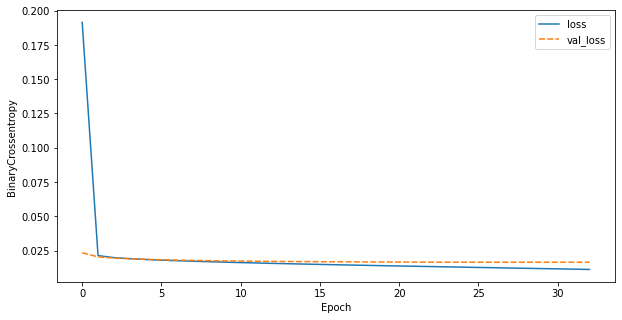

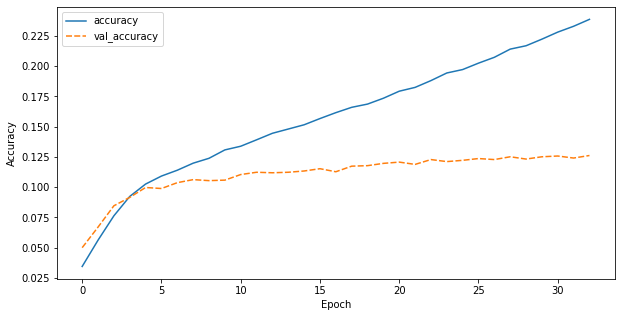

In [15]:
df_hist = pd.DataFrame(
    data=hist.history
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['loss', 'val_loss']]
)
ax.set(xlabel='Epoch', ylabel='BinaryCrossentropy')
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['accuracy', 'val_accuracy']]
)
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

###Análise dos resultados

Analisando os gráficos de treino do modelo, ele claramente sofreu de overfitting, onde o modelo "decorou" os dados de treino ao invés de aprender os padrões nos dados.

### Novo modelo mais sofisticado
Na literatura, o modo mais simples de lidar com overfitting costuma ser inserindo layers de Dropout.

Layers de dropout forçam a rede nerual a ignorar alguns valores de ativação aleatoriamente durante o treino. Isso torna a fase de aprendizado mais lenta, mas evita que a rede "decore" os dados e sofra overfitting.

Além disso, vamos adicionar layers de BatchNormalization, que são muito comuns nas aplicações de deeplearning. Estes layers normalizam os dados numericamente entre uma camada e outra da rede para uma melhor estabilidade numérica na fase de "backpropagation".

In [16]:
def make_modelo(n_sources, n_targets):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(n_sources),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(768, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n_targets, activation='sigmoid')
    ])

    optmizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )

    model.compile(
        optimizer=optmizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return model

n_sources = len(dados.loc[:, 'g-0':'g-771'].columns)
n_targets = len(dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].columns)
modelo = make_modelo(n_sources, n_targets)
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              791552    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 768)               787200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 768)               3072      
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

In [17]:
modelo = make_modelo(n_sources, n_targets)
hist = modelo.fit(
    x=x_treino,
    y=y_treino,
    batch_size=32,
    validation_data=(x_teste, y_teste),
    epochs=100, callbacks=callbacks
)   

Epoch 1/100
596/596 [==============================] - 4s 5ms/step - loss: 0.8836 - accuracy: 0.0090 - val_loss: 0.7708 - val_accuracy: 0.0223
Epoch 2/100
596/596 [==============================] - 3s 4ms/step - loss: 0.8357 - accuracy: 0.0135 - val_loss: 0.7301 - val_accuracy: 0.0355
Epoch 3/100
596/596 [==============================] - 3s 4ms/step - loss: 0.7898 - accuracy: 0.0176 - val_loss: 0.6962 - val_accuracy: 0.0420
Epoch 4/100
596/596 [==============================] - 3s 4ms/step - loss: 0.7500 - accuracy: 0.0213 - val_loss: 0.6706 - val_accuracy: 0.0481
Epoch 5/100
596/596 [==============================] - 3s 4ms/step - loss: 0.7165 - accuracy: 0.0230 - val_loss: 0.6432 - val_accuracy: 0.0489
Epoch 6/100
596/596 [==============================] - 3s 4ms/step - loss: 0.6844 - accuracy: 0.0266 - val_loss: 0.6117 - val_accuracy: 0.0508
Epoch 7/100
596/596 [==============================] - 3s 4ms/step - loss: 0.6491 - accuracy: 0.0235 - val_loss: 0.5761 - val_accuracy: 0.0512

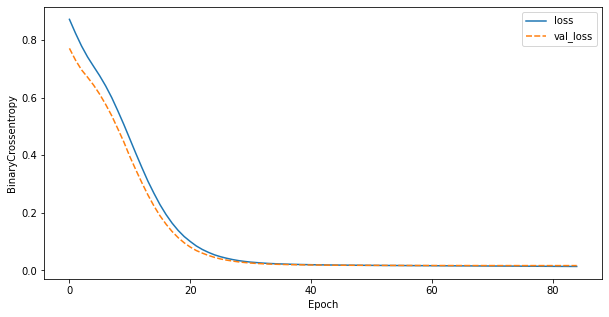

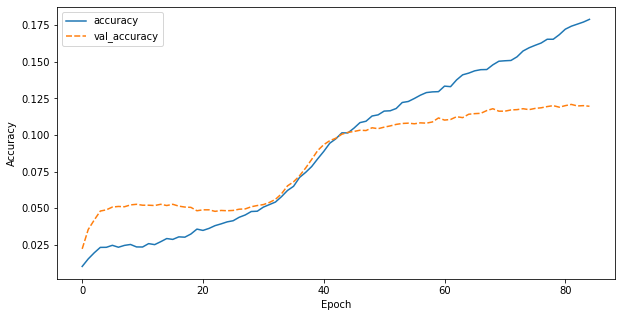

In [18]:
df_hist = pd.DataFrame(
    data=hist.history
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['loss', 'val_loss']]
)
ax.set(xlabel='Epoch', ylabel='BinaryCrossentropy')
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['accuracy', 'val_accuracy']]
)
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

## Balanceamento de Classes
Devido ao grande número de experimentos com controle quando comparado à quantidade de drogas pesquisadas, é interessante que o algoritmo enxergue os dados com uma probabilide igual para cada caso

Para realizar o desenviesamento dos dados, é usada a técnica adaptada [deste artigo](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf)

Nas células a seguir, vamos formar um gerador de amostras de treino com uma característica nova: As classes utilizas no treinamento são escolhidas com uma probabilidade proporcional ao inverso da sua frequência no dataset.

No artigo, as preocupações são principalmente focadas na identificação de faces, mas eu acredito que o método se aplique bem para qualquer dataset com desbalanceamento de classes.

![desenviesamento de rostos](https://raw.githubusercontent.com/LPugens/imersao-dados-desafio-final/main/fig5_rostos.jpg)

Criamos um dataset com a frequência de aparição de cada droga no dataset.

In [19]:
df_value_counts = dados['droga'].value_counts(normalize=True)

Calculamos a frequência de seleção de cada droga proporcional ao inverso da sua frequência no dataset. Ou seja, drogas que apareçam 1000 vezes no dataset terão a mesma probabilidade de serem vista pelo algoritmo que drogas que apareçam apenas uma vez.

In [20]:
value_counts = tf.constant(df_value_counts.values, dtype='float64')
probabilidade_de_selecao = 1/(value_counts)
probabilidade_de_selecao /= tf.reduce_sum(probabilidade_de_selecao)

A probabilidade de seleção é transformada em um dataframe e é integrada novamente ao dataset principal. Cada droga tem a sua probabilide de seleção.

Note que aqui, as probabilidades de seleção das drogas não se somam a 1, mas são o que chamamos de *logits*. Issto será normalizado pelo algoritmo de amostragem.

In [21]:
probabilidade_de_selecao = pd.DataFrame(
        data=probabilidade_de_selecao,
        index = df_value_counts.index,
        columns=['probabilidade_de_selecao']
    )
probabilidade_de_selecao.reset_index(inplace=True)
probabilidade_de_selecao.rename({'index': 'droga'}, axis=1, inplace=True)
dados = pd.merge(
    dados,
    probabilidade_de_selecao,
    on='droga'
)

Um gerador no formato `(x, y)` que seleciona as batches com as probabilidades de seleção informadas em `p`.

In [22]:
def generator_with_logits(X, Y, p):
    p = p/sum(p)
    while True:
        samples = np.random.choice(X.shape[0], size=32, p=p)
        x = tf.constant(X.iloc[samples].values, dtype='float64')
        y = tf.constant(Y.iloc[samples].values, dtype='int16')
        yield (x, y) 

Dividimos os dados em treino e teste.

Preciso amostrar os dados novamente, incluindo a informação de `probabilidade_de_selecao` desta vez. Selecionar o modelo pela função `train_test_split` do ScikitLearn para ter um balanceamento de classes.

In [23]:
X = dados.loc[:, 'g-0':'g-771']
X = pd.concat(
    [X, dados['probabilidade_de_selecao']],
    axis=1
).values
Y = dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].values

x_treino, x_teste, y_treino, y_teste = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=25081994)
p_treino = x_treino[:, -1]
x_treino = x_treino[:, :-1]
x_teste = x_teste[:, :-1]

Preciso transformar os dados novamente em dataframes por causa das suas capacidades de indexar seus dados randomicamente.

In [24]:
x_treino = pd.DataFrame(
    data=x_treino,
    columns=dados.loc[:, 'g-0':'g-771'].columns
)
y_treino = pd.DataFrame(
    data=y_treino,
    columns=dados.loc[:, '11-beta-hsd1_inhibitor':'nrf2_activator'].columns
)

Instanciação do gerador de treino.

In [25]:
train_generator = generator_with_logits(x_treino, y_treino, p_treino)

Treinamento do modelo com desenviesamento de dados

In [26]:
modelo = make_modelo(n_sources, n_targets)
hist = modelo.fit(
    x=train_generator,
    steps_per_epoch = 1000,
    validation_data=(x_teste, y_teste),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
1000/1000 [==============================] - 6s 5ms/step - loss: 0.8785 - accuracy: 0.0067 - val_loss: 0.7734 - val_accuracy: 0.0128
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8101 - accuracy: 0.0091 - val_loss: 0.7154 - val_accuracy: 0.0122
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7463 - accuracy: 0.0095 - val_loss: 0.6515 - val_accuracy: 0.0141
Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6863 - accuracy: 0.0094 - val_loss: 0.5865 - val_accuracy: 0.0160
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6228 - accuracy: 0.0085 - val_loss: 0.5148 - val_accuracy: 0.0153
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5450 - accuracy: 0.0092 - val_loss: 0.4355 - val_accuracy: 0.0141
Epoch 7/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4604 - accuracy: 0.0064 - val_loss: 0.3529 - val_ac

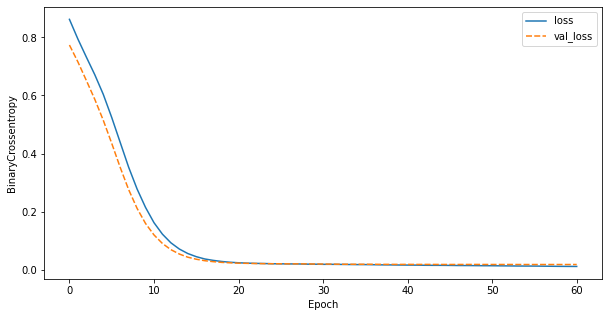

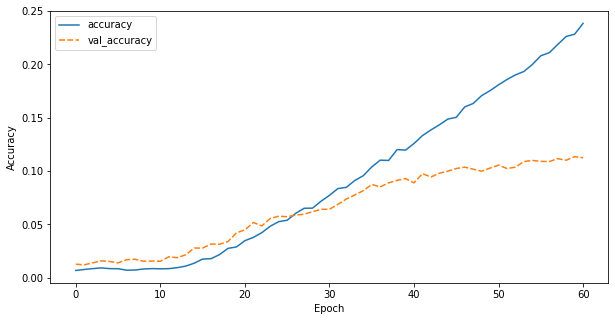

In [27]:
df_hist = pd.DataFrame(
    data=hist.history
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['loss', 'val_loss']]
)
ax.set(xlabel='Epoch', ylabel='BinaryCrossentropy')
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=df_hist[['accuracy', 'val_accuracy']]
)
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

#Conclusão
A aplicação escolhida foi uma das tarefas mais desafiadoras e relevantes que pode ser extraída destes dados.

Utilizando os métodos mencionados, nenhum deles fez grande efeito nos resultado geral de acurácia, que ficou em geral em torno de **12%** no conjunto de teste.